In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams.update({'font.size': 20})

(132416, 384) (132416, 384)
(91, 5, 384) (91, 5, 384)


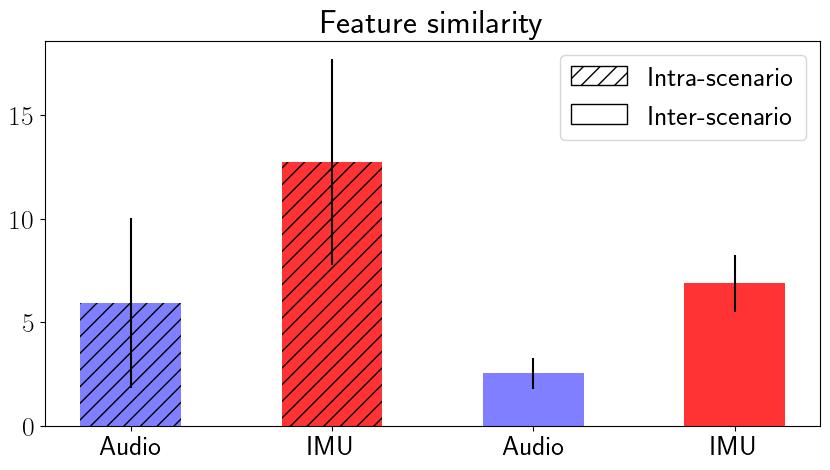

In [45]:
import numpy as np
embeddings_file = '../resources/bodysound/embeddings.npz'
embeddings = np.load(embeddings_file, allow_pickle=True)
print(embeddings['audio'].shape, embeddings['imu'].shape)
num_samples = embeddings['audio'].shape[0]

scenario = embeddings['scenario'] # [num, num_class]

def class_wise_feature(embeddings, scenario, num=10):
    num_samples, num_class = scenario.shape
    num_samples, num_features = embeddings.shape
    class_wise_features = np.zeros((num_class, num, num_features))
    for i in range(num_class):
        mask = scenario[:, i].astype(np.bool_)
        if np.sum(mask) == 0:
            continue
        embedding_mask = embeddings[mask]
        if embedding_mask.shape[0] < num:
            class_wise_features[i, :embedding_mask.shape[0], :] = embedding_mask
        else:
            class_wise_features[i] = embedding_mask[:num]
        class_wise_features[i] = np.mean(embeddings[mask], axis=0)
    return class_wise_features

def similarity_diff(class_wise_features):
    similarity = []
    for i in range(class_wise_features.shape[0]):
        scenario_feature = class_wise_features[i]
        other_feature = np.concatenate([class_wise_features[:i], class_wise_features[i+1:]], axis=0)
        other_feature = other_feature.reshape(-1, class_wise_features.shape[-1])
        self_similarity = np.mean(np.dot(scenario_feature, scenario_feature.T))
        other_similarity = np.mean(np.dot(scenario_feature, other_feature.T))
        similarity.append([self_similarity, other_similarity])
    return similarity


audio_class_wise_features = class_wise_feature(embeddings['audio'], scenario, num=5)
imu_class_wise_features = class_wise_feature(embeddings['imu'], scenario, num=5)
print(audio_class_wise_features.shape, imu_class_wise_features.shape)

audio_similariy = similarity_diff(audio_class_wise_features)
imu_similariy = similarity_diff(imu_class_wise_features)
plt.figure(figsize=(10, 5))
plt.bar(0, np.mean(audio_similariy, axis=0)[0], yerr=np.std(audio_similariy, axis=0)[0], color='b', hatch='//', alpha=0.5, width=0.5)
plt.bar(1, np.mean(imu_similariy, axis=0)[0], yerr=np.std(imu_similariy, axis=0)[0], color='r', hatch='//', alpha=0.8, width=0.5)

plt.bar(2, np.mean(audio_similariy, axis=0)[1], yerr=np.std(audio_similariy, axis=0)[1], color='b', alpha=0.5, width=0.5)
plt.bar(3, np.mean(imu_similariy, axis=0)[1], yerr=np.std(imu_similariy, axis=0)[1], color='r', alpha=0.8, width=0.5)
plt.xticks([0, 1, 2, 3], ['Audio', 'IMU', 'Audio', 'IMU'])

plt.legend([mpatches.Patch(facecolor='w', hatch='//', edgecolor='black'), mpatches.Patch(facecolor='w', edgecolor='black')], ['Intra-scenario', 'Inter-scenario'])
plt.title('Feature similarity')
plt.savefig('../figs/feature_similarity.pdf')
    


/home/lixing/miniconda3/envs/har/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


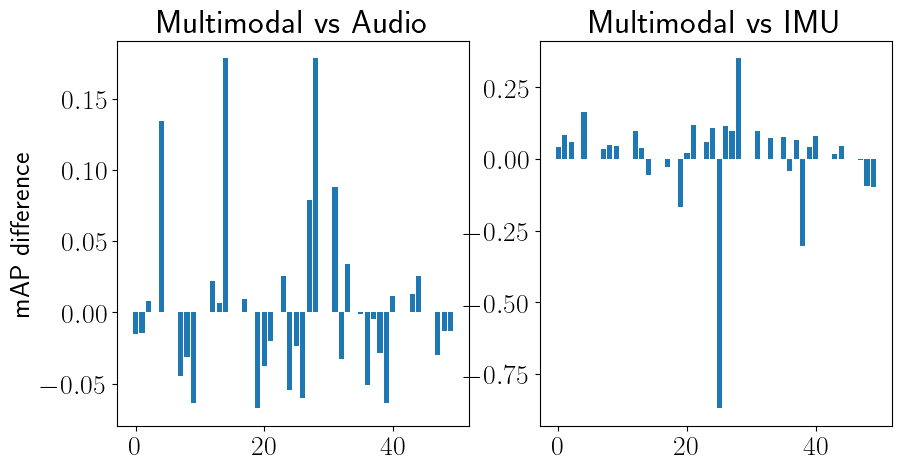

In [24]:
import numpy as np
import torch
import torchmetrics

multimodal_gts = np.load('../resources/activity/gts.npy')
multimodal_preds = np.load('../resources/activity/preds.npy')
mAP = torchmetrics.Accuracy(task='multiclass', num_classes=50, average=None)
mAP_val = mAP(torch.tensor(multimodal_gts), torch.tensor(multimodal_preds))

audio_gts = np.load('../resources/activity_audio/gts.npy')
audio_preds = np.load('../resources/activity_audio/preds.npy')
mAP = torchmetrics.Accuracy(task='multiclass', num_classes=50, average=None)
mAP_val_audio = mAP(torch.tensor(audio_gts), torch.tensor(audio_preds))

imu_gts = np.load('../resources/activity_imu/gts.npy')
imu_preds = np.load('../resources/activity_imu/preds.npy')
mAP = torchmetrics.Accuracy(task='multiclass', num_classes=50, average=None)
mAP_val_imu = mAP(torch.tensor(imu_gts), torch.tensor(imu_preds))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(np.arange(50), mAP_val - mAP_val_audio, color='tab:blue')
axs[0].set_title('Multimodal vs Audio')
axs[0].set_ylabel('mAP difference')
axs[1].bar(np.arange(50), mAP_val - mAP_val_imu, color='tab:blue')
axs[1].set_title('Multimodal vs IMU')
plt.savefig('../figs/activity_diff.pdf')

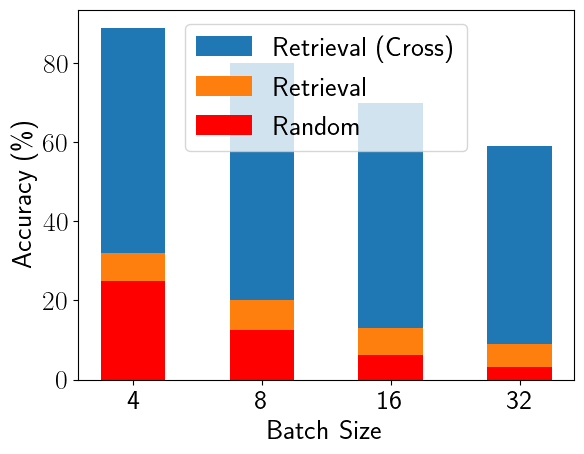

In [3]:
# Motivation 1
retrieval_cross = [89, 80, 70, 59]
retrieval = [32, 20, 13, 9]
random = [25, 12.5, 6.25, 3.125]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(retrieval_cross)), retrieval_cross, label='Retrieval (Cross)', width=0.5)
ax.bar(range(len(retrieval)), retrieval, label='Retrieval', width=0.5)
ax.bar(range(len(random)), random, label='Random', width=0.5, color='red')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Accuracy (\%)')
ax.legend()
ax.set_xticks(range(len(retrieval)), [4, 8, 16, 32])
plt.savefig('../figs/retrieval.pdf', bbox_inches='tight')


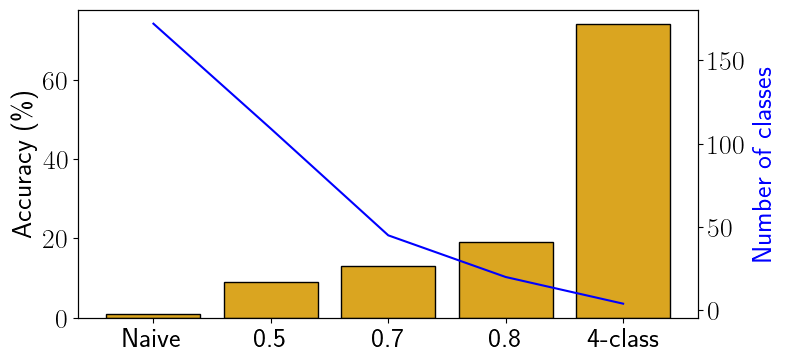

In [4]:
# Motivation 2
acc = [1, 9, 13, 19, 74]
num_class = [172, 109, 45, 20, 4]
names = ['Naive', '0.5', '0.7', '0.8', '4-class']
# colors = ['goldenrod', 'chocolate', 'forestgreen', 'green']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.bar(range(len(acc)), acc, edgecolor='black', color='goldenrod', width=0.8)
ax.set_xticks(range(len(acc)), names)
ax2 = ax.twinx()
ax2.plot(range(len(acc)), num_class, color='b')

ax.set_ylabel('Accuracy (\%)')
ax2.set_ylabel('Number of classes', color='b')
plt.savefig('../figs/acc_num_class.pdf')

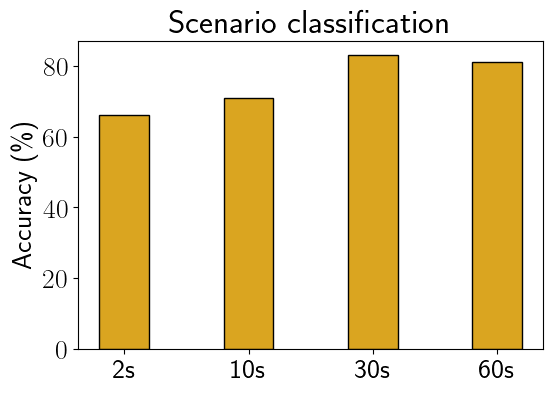

In [36]:
scenario_cls_acc = [66, 71, 83, 81]
sequence_length = ['2s', '10s', '30s', '60s']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.bar(range(len(sequence_length)), scenario_cls_acc, edgecolor='black', color='goldenrod', width=0.4)
ax.set_xticks(range(len(sequence_length)), sequence_length)
ax.set_ylabel('Accuracy (\%)')
ax.set_title('Scenario classification')
plt.savefig('../figs/scenario_sequence.pdf')

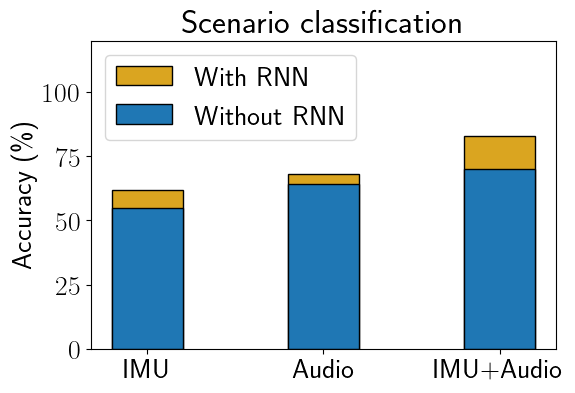

In [43]:
scenario_cls_acc = [62, 68, 83]
scenario_cls_name = ['IMU', 'Audio', 'IMU+Audio']

scenario_cls_acc_wo_rnn = [55, 64, 70]


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.bar(range(len(scenario_cls_acc)), scenario_cls_acc, edgecolor='black', color='goldenrod', width=0.4, label='With RNN')

ax.bar(range(len(scenario_cls_acc_wo_rnn)), scenario_cls_acc_wo_rnn, edgecolor='black', width=0.4, label='Without RNN')

ax.set_xticks(range(len(scenario_cls_acc)), scenario_cls_name)
ax.set_ylabel('Accuracy (\%)')
ax.set_title('Scenario classification')

# set legend to left of the plot
ax.legend(loc='upper left')
ax.set_ylim([0, 120])
plt.savefig('../figs/scenario_cls.pdf')

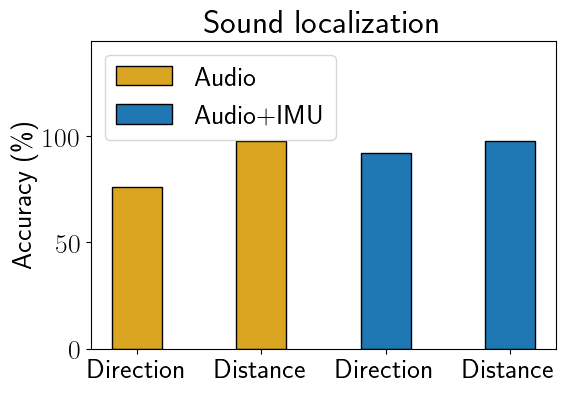

In [13]:
accuracy_location = [76, 98, 92, 98]
name_location = ['Direction', 'Distance', 'Direction', 'Distance']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.bar(range(2), accuracy_location[:2], edgecolor='black', color='goldenrod', width=0.4, label='Audio')
ax.bar(range(2, 4), accuracy_location[2:], edgecolor='black', color='tab:blue', width=0.4, label='Audio+IMU')

ax.set_xticks(range(len(name_location)), name_location)
ax.set_ylabel('Accuracy (\%)')
ax.set_title('Sound localization')
plt.legend(loc='upper left')
plt.ylim([0, 145])
plt.savefig('../figs/sound_localization.pdf')

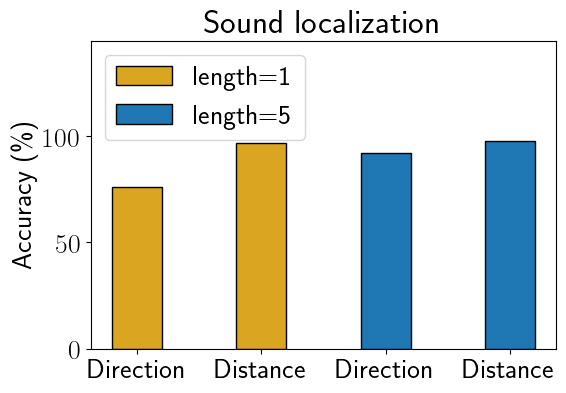

In [11]:
accuracy_location = [76, 97, 92, 98]
name_location = ['Direction', 'Distance', 'Direction', 'Distance']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.bar(range(2), accuracy_location[:2], edgecolor='black', color='goldenrod', width=0.4, label='length=1')
ax.bar(range(2, 4), accuracy_location[2:], edgecolor='black', color='tab:blue', width=0.4, label='length=5')

ax.set_xticks(range(len(name_location)), name_location)
ax.set_ylabel('Accuracy (\%)')
ax.set_title('Sound localization')
plt.legend(loc='upper left')
plt.ylim([0, 145])
plt.savefig('../figs/sound_localization_length.pdf')

0 [92, 98]
1 [84, 71]
2 [80, 78]
3 [75, 95]
4 [86, 77]
5 [71, 82]
6 [81, 84]


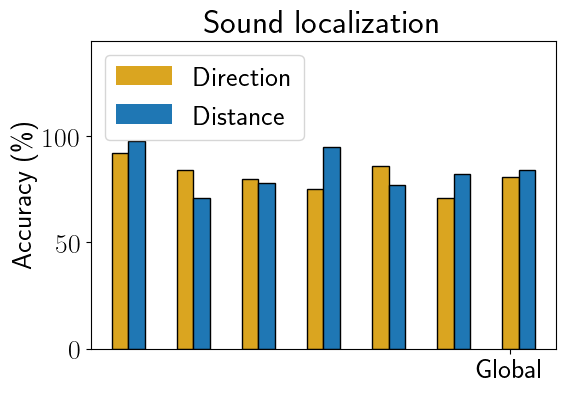

In [4]:
accuracy_location = [[92, 98], [84, 71], [80, 78], [75, 95], [86, 77], [71, 82], [81, 84]]
name_location = ['Direction', 'Distance', 'Direction', 'Distance']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
for i, acc in enumerate(accuracy_location):
    print(i, acc)
    ax.bar([i], acc[0], edgecolor='black', width=0.25,color='goldenrod',)
    ax.bar([i+0.25], acc[1], edgecolor='black', width=0.25,color='tab:blue')
# ax.bar(range(2), accuracy_location[:2], edgecolor='black', color='goldenrod', width=0.4, label='length=1')
# ax.bar(range(2, 4), accuracy_location[2:], edgecolor='black', color='tab:blue', width=0.4, label='length=5')

ax.set_xticks(range(len(accuracy_location)))
ax.set_xticks([len(accuracy_location)-1], ['Global'])
ax.set_ylabel('Accuracy (\%)')
ax.set_title('Sound localization')
# legend with different colors,
ax.legend([mpatches.Patch(facecolor='goldenrod'), mpatches.Patch(facecolor='tab:blue')], ['Direction', 'Distance'], loc='upper left')
ax.set_ylim([0, 145])

plt.savefig('../figs/sound_localization_user.pdf')

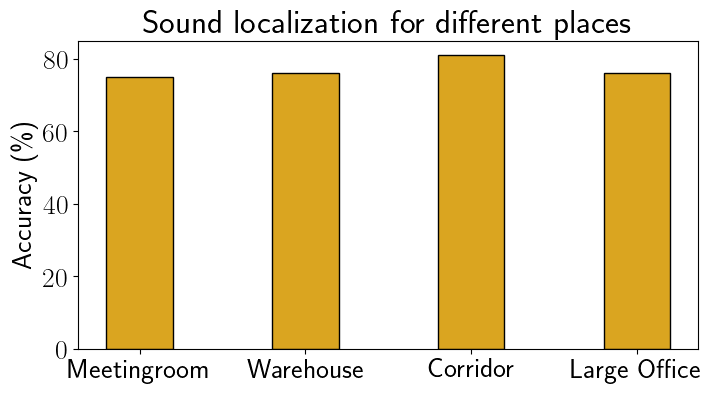

In [ ]:
accuracy_location = [75,76, 81, 76]
name_location = ['Meetingroom', 'Warehouse', 'Corridor', 'Large Office']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.bar(range(len(accuracy_location)), accuracy_location, edgecolor='black', color='goldenrod', width=0.4)
ax.set_xticks(range(len(name_location)), name_location)

plt.ylabel('Accuracy (\%)')
plt.title('Sound localization for different places')
plt.savefig('../figs/sound_localization_place.pdf')

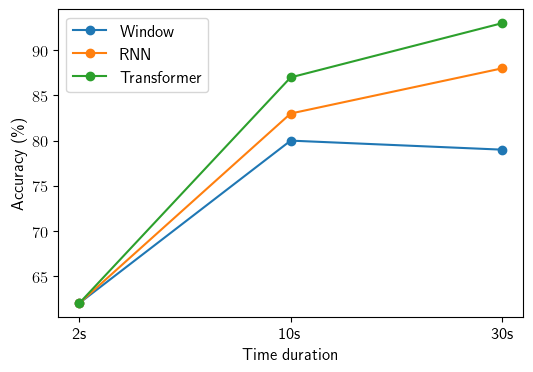

In [9]:
window_acc = [62, 69, 70]
rnn_acc = [75, 82, 88]
transformer_acc = [62, 87, 93]

time_name = ['2s', '10s', '30s']

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(range(len(window_acc)), window_acc, label='Window', marker='o')
ax.plot(range(len(rnn_acc)), rnn_acc, label='RNN', marker='o')
ax.plot(range(len(transformer_acc)), transformer_acc, label='Transformer', marker='o')
ax.set_xticks(range(len(window_acc)), time_name)

ax.set_ylabel('Accuracy (\%)')
ax.set_xlabel('Time duration')
ax.legend()

